# [**Prévision du niveau de CO2 sur l'ensemble de données de Mona Loa à l'aide de la régression des processus gaussiens (GPR)**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_7_gaussian_process/plot_gpr_co2.ipynb)<br/>([_Forecasting of CO2 level on Mona Loa dataset using Gaussian process regression (GPR)_](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html))

Cet exemple est basé sur la section 5.4.3 de "Gaussian Processes for Machine Learning" [RW2006]. Il illustre un exemple d'ingénierie de noyaux complexes et d'optimisation des hyperparamètres à l'aide de la montée en gradient de la log-vraisemblance. Les données consistent en des concentrations mensuelles moyennes d'oxyde de carbone atmosphérique (en parties par million en volume (ppm)) collectées à l'observatoire de Mauna Loa à Hawaï, entre 1958 et 2001. L'objectif est de modéliser la concentration en CO2 en fonction du temps et d'extrapoler pour les années après 2001.

In [1]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

Automatically created module for IPython interactive environment


# Construction de l'ensemble de données

Nous allons créer un ensemble de données à partir de l'observatoire de Mauna Loa qui a collecté des échantillons d'air. Nous souhaitons estimer la concentration de CO2 et l'extrapoler pour les années à venir. Tout d'abord, nous chargeons l'ensemble de données d'origine disponible dans OpenML.

In [2]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


Tout d'abord, nous traitons le dataframe d'origine pour créer un index de date et ne sélectionner que la colonne du CO2.

In [3]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

Nous constatons que nous avons des concentrations de CO2 pour certains jours de mars 1958 à décembre 2001. Nous pouvons représenter ces informations brutes pour mieux les comprendre.

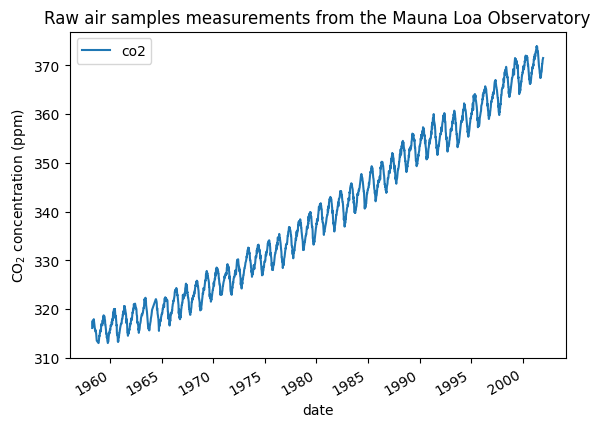

In [5]:
import matplotlib.pyplot as plt

co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

Nous pré-traiterons le jeu de données en prenant une moyenne mensuelle et en supprimant les mois pour lesquels aucune mesure n'a été collectée. Un tel traitement aura un effet lissant sur les données.

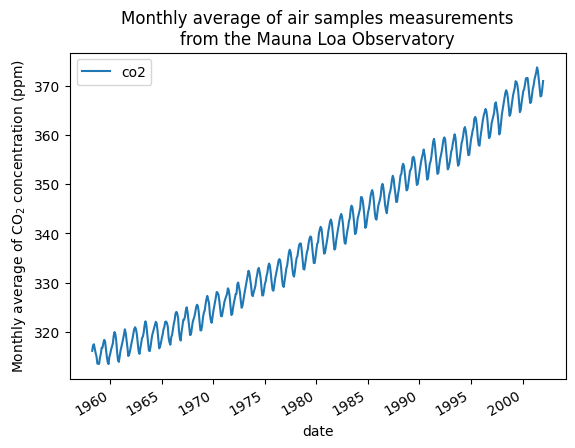

In [6]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

L'idée dans cet exemple sera de prédire la concentration de CO2 en fonction de la date. Nous sommes également intéressés par l'extrapolation pour les années à venir après 2001.

Comme première étape, nous diviserons les données et la cible à estimer. Les données étant une date, nous les convertirons en valeur numérique.

In [7]:
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

# Conception du noyau approprié

Pour concevoir le noyau à utiliser avec notre processus gaussien, nous pouvons faire des hypothèses concernant les données en main. Nous observons qu'elles ont plusieurs caractéristiques : nous voyons une tendance à long terme à la hausse, une variation saisonnière prononcée et quelques irrégularités plus petites. Nous pouvons utiliser différents noyaux appropriés pour capturer ces caractéristiques.

Tout d'abord, la tendance à la hausse à long terme pourrait être ajustée en utilisant un noyau à base radiale (RBF) avec un grand paramètre d'échelle de longueur. Le noyau RBF avec un grand paramètre d'échelle impose que cette composante soit lisse. Une augmentation tendancielle n'est pas imposée pour donner une certaine liberté à notre modèle. La longueur d'échelle spécifique et l'amplitude sont des hyperparamètres libres.

In [8]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

La variation saisonnière est expliquée par le noyau exponentiel sinusoïdal périodique avec une périodicité fixe d'un an. La longueur d'échelle de cette composante périodique, qui contrôle sa douceur, est un paramètre libre. Pour permettre un éloignement de la périodicité exacte, le produit avec un noyau RBF est pris. La longueur d'échelle de cette composante RBF contrôle le temps de décroissance et est un autre paramètre libre. Ce type de noyau est également connu sous le nom de noyau localement périodique.

In [9]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

Les petites irrégularités doivent être expliquées par une composante de noyau quadratique rationnel, dont la longueur d'échelle et le paramètre alpha, qui quantifie la diffusion des longueurs d'échelle, doivent être déterminés. Un noyau quadratique rationnel est équivalent à un noyau RBF avec plusieurs longueurs d'échelle et s'adaptera mieux aux différentes irrégularités.

In [10]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

Enfin, le bruit dans l'ensemble de données peut être pris en compte avec une contribution de noyau composée d'une contribution de noyau RBF, qui explique les composantes de bruit corrélées telles que les phénomènes météorologiques locaux, et d'une contribution de noyau blanc pour le bruit blanc. Les amplitudes relatives et l'échelle de longueur de l'RBF sont d'autres paramètres libres.

In [11]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

Ainsi, notre noyau final est une addition de tous les noyaux précédents.

In [12]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

# Ajustement du modèle et extrapolation

Maintenant, nous sommes prêts à utiliser un régresseur de processus gaussien et à ajuster les données disponibles. Pour suivre l'exemple de la littérature, nous soustrairons la moyenne de la cible. Nous aurions pu utiliser `normalize_y=True`. Cependant, en faisant cela, la cible aurait également été mise à l'échelle (en divisant `y` par son écart-type). Ainsi, les hyperparamètres des différents noyaux auraient eu une signification différente car ils n'auraient pas été exprimés en ppm.

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

Maintenant, nous utiliserons le processus gaussien pour prédire :
- les données d'entraînement pour inspecter la qualité de l'ajustement ;
- les données futures pour voir l'extrapolation effectuée par le modèle.

Ainsi, nous créons des données synthétiques de 1958 au mois en cours. De plus, nous devons ajouter la moyenne soustraite calculée lors de l'entraînement.

In [14]:
import datetime

import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

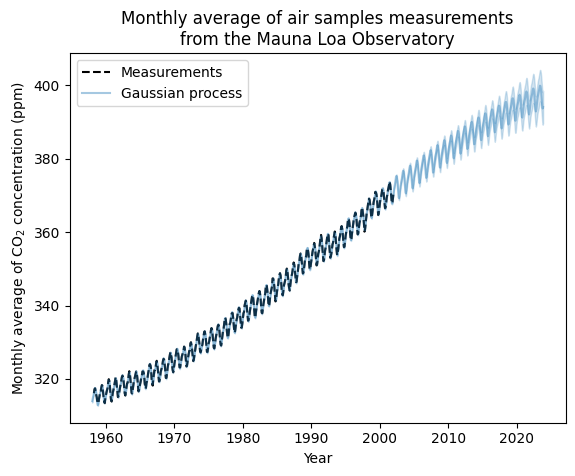

In [15]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

Notre modèle ajusté est capable de bien s'ajuster aux données précédentes et d'extrapoler pour les années à venir avec confiance.

# Interprétation des hyperparamètres du noyau

Maintenant, nous pouvons jeter un coup d'œil aux hyperparamètres du noyau.

In [16]:
gaussian_process.kernel_

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

: 

Ainsi, la plupart du signal cible, avec la moyenne soustraite, est expliquée par une tendance à long terme à la hausse d'environ 45 ppm et une échelle de longueur d'environ 52 ans. La composante périodique a une amplitude d'environ 2,6 ppm, un temps de décroissance d'environ 90 ans et une longueur d'échelle d'environ 1,5. Le temps de décroissance élevé indique que nous avons une composante très proche d'une périodicité saisonnière. Le bruit corrélé a une amplitude d'environ 0,2 ppm avec une échelle de longueur d'environ 0,12 ans et une contribution de bruit blanc d'environ 0,04 ppm. Ainsi, le niveau de bruit global est très faible, ce qui indique que les données peuvent être très bien expliquées par le modèle.